# Time Series Analysis — ARMAModel
## RELIANCE.NS | 2005 | With Stationarity Phase

**Pipeline:**
1. Data Collection (yfinance)
2. **Stationarity Testing (ADF Test)**
3. **Differencing + ACF/PACF Analysis**
4. Normalization (MinMaxScaler on stationary data)
5. Train/Test Split
6. AR Model Grid Search
7. Best Model Evaluation
8. Inverse Transform → Original Price Scale
9. Forecasting

---
## Step 1: Install & Import Libraries

In [1]:
!pip install yfinance statsmodels scikit-learn matplotlib --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Step 2: Download Stock Data

In [3]:
ticker = "RELIANCE.NS"
year = 2005
start_date = f"{year}-01-01"
end_date   = f"{year}-12-31"

stk_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if stk_data.empty:
    print(f"No data available for {ticker} in {year}.")
else:
    stk_data = stk_data[["Open", "High", "Low", "Close"]]
    print(f"OHLC data for {ticker} in {year}:")
    print(stk_data.head())
    print(f"\nShape: {stk_data.shape}")

OHLC data for RELIANCE.NS in 2005:
Price             Open        High         Low       Close
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                      
2005-01-03   32.366294   32.702319   32.030269   32.633312
2005-01-04   33.002339   33.002339   31.778253   31.877260
2005-01-05   31.562235   32.009267   30.971193   31.799250
2005-01-06   31.682238   32.192275   31.337211   31.574232
2005-01-07   32.102271   32.864324   31.655240   32.537300

Shape: (250, 4)


In [4]:
column = "Close"
close_prices = stk_data[[column]].copy()
close_prices.head()

Price,Close
Ticker,RELIANCE.NS
Date,
2005-01-03,32.633312
2005-01-04,31.877260
2005-01-05,31.799250
2005-01-06,31.574232
2005-01-07,32.537300


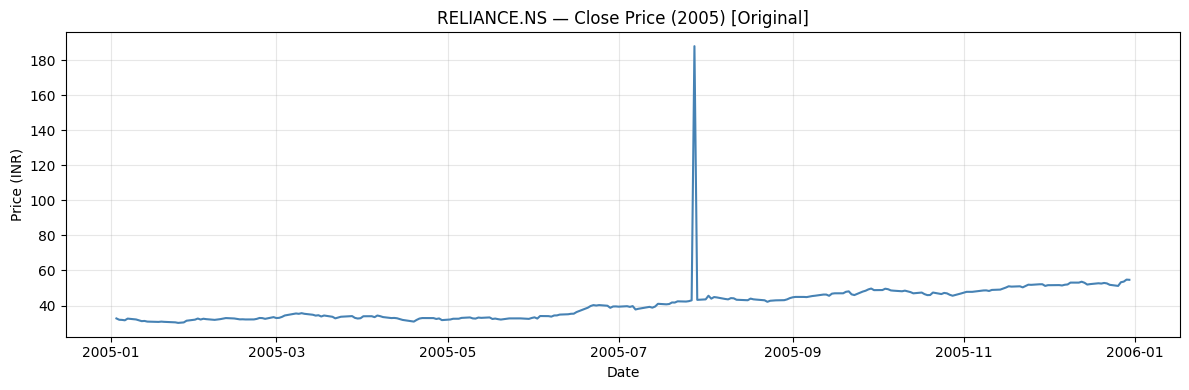

In [5]:
# Visualize raw Close price
plt.figure(figsize=(12, 4))
plt.plot(close_prices, color='steelblue', linewidth=1.5)
plt.title(f"{ticker} — Close Price ({year}) [Original]")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## ⚡ Step 3: Stationarity Phase

### Why Stationarity Matters?
AR models assume the time series is **stationary** — meaning:
- Constant mean over time
- Constant variance over time
- No systematic trend or seasonality

Non-stationary data causes **spurious regression** — the model fits noise rather than real patterns.

### Test: Augmented Dickey-Fuller (ADF)
- **H₀ (Null):** Series has a unit root → **Non-stationary**
- **H₁ (Alt):** Series is **stationary**
- **Rule:** If p-value < 0.05 → Reject H₀ → Series is **Stationary** ✅

In [6]:
def adf_test(series, series_name="Series"):
    """
    Performs Augmented Dickey-Fuller test and prints a clean report.
    Returns True if stationary, False otherwise.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    adf_stat   = result[0]
    p_value    = result[1]
    used_lags  = result[2]
    n_obs      = result[3]
    crit_vals  = result[4]
    
    print("="*55)
    print(f"  ADF Stationarity Test — {series_name}")
    print("="*55)
    print(f"  ADF Statistic  : {adf_stat:.6f}")
    print(f"  p-value        : {p_value:.6f}")
    print(f"  Lags Used      : {used_lags}")
    print(f"  Observations   : {n_obs}")
    print("  Critical Values:")
    for key, val in crit_vals.items():
        marker = "<-- ADF" if adf_stat < val else ""
        print(f"    {key}: {val:.4f}  {marker}")
    print("-"*55)
    
    if p_value < 0.05:
        print(f"  ✅ RESULT: STATIONARY  (p={p_value:.4f} < 0.05)")
        stationary = True
    else:
        print(f"  ❌ RESULT: NON-STATIONARY  (p={p_value:.4f} ≥ 0.05)")
        print(f"     → Differencing required!")
        stationary = False
    print("="*55)
    return stationary

In [7]:
# ---- ADF Test on Original Close Price ----
is_stationary = adf_test(close_prices[column], series_name="Close Price (Original)")

  ADF Stationarity Test — Close Price (Original)
  ADF Statistic  : -2.231289
  p-value        : 0.195086
  Lags Used      : 6
  Observations   : 243
  Critical Values:
    1%: -3.4576  
    5%: -2.8735  
    10%: -2.5731  
-------------------------------------------------------
  ❌ RESULT: NON-STATIONARY  (p=0.1951 ≥ 0.05)
     → Differencing required!


### Step 3.2: Apply First-Order Differencing

**Formula:** `y'(t) = y(t) - y(t-1)`

Differencing removes trend by computing day-over-day price change.  
The first row becomes NaN (no prior value) — we drop it.

In [8]:
close_diff = close_prices[column].diff().dropna()

print(f"Original series length   : {len(close_prices)}")
print(f"Differenced series length: {len(close_diff)}")
print(f"\nFirst 5 differenced values:\n{close_diff.head()}")
print(f"\nMean of differenced series : {float(close_diff.mean()):.4f}")
print(f"Std  of differenced series : {float(close_diff.std()):.4f}")

Original series length   : 250
Differenced series length: 249

First 5 differenced values:
Ticker      RELIANCE.NS
Date                   
2005-01-04    -0.756052
2005-01-05    -0.078011
2005-01-06    -0.225018
2005-01-07     0.963068
2005-01-10    -0.486027

Mean of differenced series : 0.0885
Std  of differenced series : 13.0234


In [9]:
# ---- ADF Test on Differenced Series ----
is_stationary_diff = adf_test(close_diff, series_name="Close Price (1st Order Differenced)")

  ADF Stationarity Test — Close Price (1st Order Differenced)
  ADF Statistic  : -9.054552
  p-value        : 0.000000
  Lags Used      : 7
  Observations   : 241
  Critical Values:
    1%: -3.4578  <-- ADF
    5%: -2.8736  <-- ADF
    10%: -2.5732  <-- ADF
-------------------------------------------------------
  ✅ RESULT: STATIONARY  (p=0.0000 < 0.05)


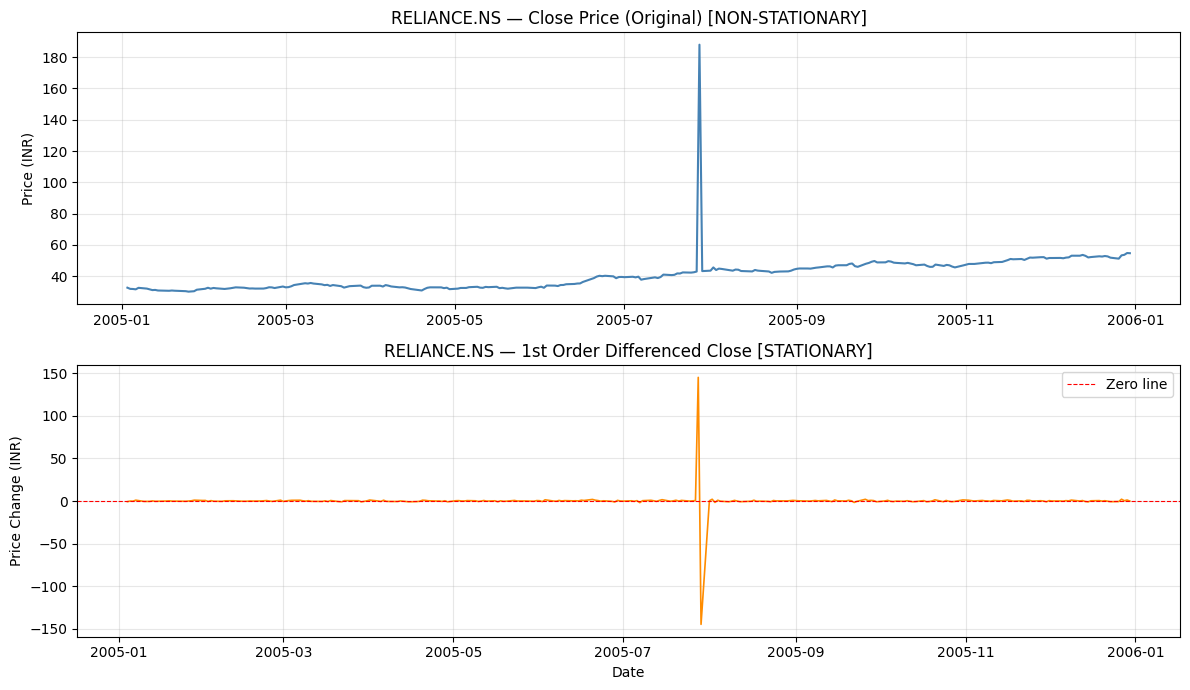

In [10]:
# Visualize: Original vs Differenced
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

axes[0].plot(close_prices[column], color='steelblue', linewidth=1.5)
axes[0].set_title(f"{ticker} — Close Price (Original) [NON-STATIONARY]", fontsize=12)
axes[0].set_ylabel("Price (INR)")
axes[0].grid(alpha=0.3)

axes[1].plot(close_diff, color='darkorange', linewidth=1.2)
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero line')
axes[1].set_title(f"{ticker} — 1st Order Differenced Close [STATIONARY]", fontsize=12)
axes[1].set_ylabel("Price Change (INR)")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3.3: ACF & PACF Analysis

- **ACF (Autocorrelation Function):** Correlation of series with its lags — helps identify MA order
- **PACF (Partial Autocorrelation Function):** Direct correlation at each lag (removing intermediate) — helps identify **AR order** (number of lags)

**Rule:** For AR model, use the last lag where PACF is significant (outside blue band)

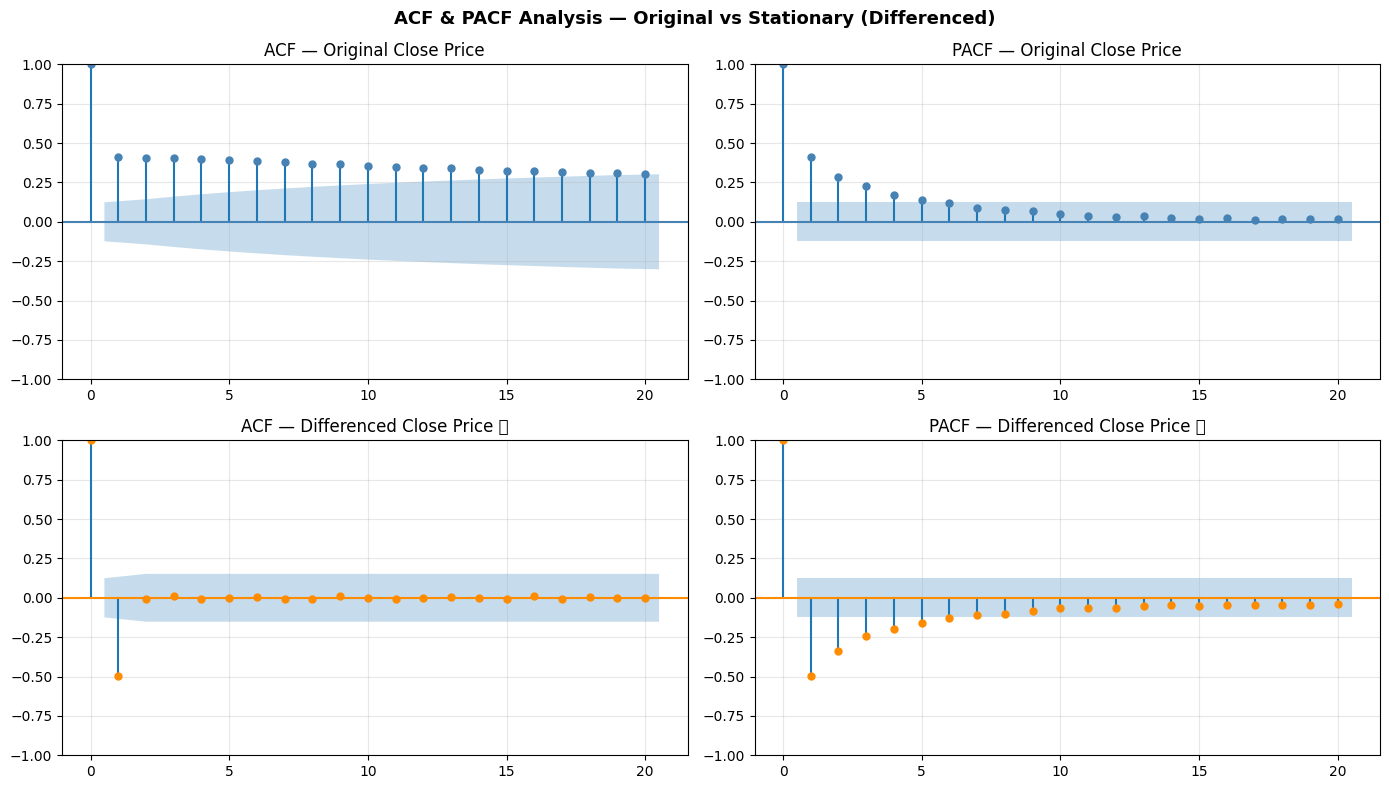


📌 Interpretation:
  - In PACF of Differenced series: significant lags = suggested AR lags
  - ACF cuts off quickly in differenced series → confirms stationarity


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF - Original
plot_acf(close_prices[column], lags=20, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("ACF — Original Close Price")

# PACF - Original
plot_pacf(close_prices[column], lags=20, ax=axes[0, 1], method='ywm', color='steelblue')
axes[0, 1].set_title("PACF — Original Close Price")

# ACF - Differenced
plot_acf(close_diff, lags=20, ax=axes[1, 0], color='darkorange')
axes[1, 0].set_title("ACF — Differenced Close Price ✅")

# PACF - Differenced
plot_pacf(close_diff, lags=20, ax=axes[1, 1], method='ywm', color='darkorange')
axes[1, 1].set_title("PACF — Differenced Close Price ✅")

for ax in axes.flatten():
    ax.grid(alpha=0.3)

plt.suptitle("ACF & PACF Analysis — Original vs Stationary (Differenced)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 Interpretation:")
print("  - In PACF of Differenced series: significant lags = suggested AR lags")
print("  - ACF cuts off quickly in differenced series → confirms stationarity")

---
## Step 4: Normalization (on Stationary/Differenced Data)

In [12]:
# Store last training value for inverse differencing later
# We'll compute this after the train split

Ms = MinMaxScaler()

# Fit and transform differenced series
data1 = Ms.fit_transform(close_diff.values.reshape(-1, 1))

print(f"Differenced + Normalized data shape: {data1.shape}")
print(f"Min value after scaling: {data1.min():.4f}")
print(f"Max value after scaling: {data1.max():.4f}")

Differenced + Normalized data shape: (249, 1)
Min value after scaling: 0.0000
Max value after scaling: 1.0000


---
## Step 5: Train / Test Split (80/20)

In [13]:
training_size = round(len(data1) * 0.80)
print(f"Training size : {training_size}")
print(f"Test size     : {len(data1) - training_size}")

X_train = data1[:training_size]
X_test  = data1[training_size:]
y_train = data1[:training_size]
y_test  = data1[training_size:]

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

last_train_price = float(close_prices[column].iloc[training_size])
print(f"\nLast original close price at train boundary: {last_train_price:.2f} INR")

Training size : 199
Test size     : 50

X_train shape: (199, 1)
X_test shape : (50, 1)

Last original close price at train boundary: 46.51 INR


---
## Step 6: AR Model Grid Search (on Stationary Data)

In [14]:
def rmsemape(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    if label:
        print(f"  [{label}] RMSE: {rmse:.6f} | MAPE: {mape:.6f}")
    return rmse, mape

In [15]:
orders=[(1,0,2),(1,0,1),(2,0,1),(1,0,1)]
#orderslist=[]
#rscorelist=[]
for i in orders:
    #orderslist.append(i)
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(data1, order=i)
    model_fit = model.fit()
    # make prediction
    y_pred= model_fit.predict(0, len(data1)-1)
    #print(y_pred)
    from stockFunctions import rmsemape
    rmsemape(data1,y_pred)
    

RMSE-Testset: 0.03293934291912182
MAPE-Testset: 953328923758.8315


C:\Users\gnana\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE-Testset: 0.03282475068816347
MAPE-Testset: 517889119725.1635
RMSE-Testset: 0.03281977929152838
MAPE-Testset: 513649726529.6293
RMSE-Testset: 0.03282475068816347
MAPE-Testset: 517889119725.1635


C:\Users\gnana\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


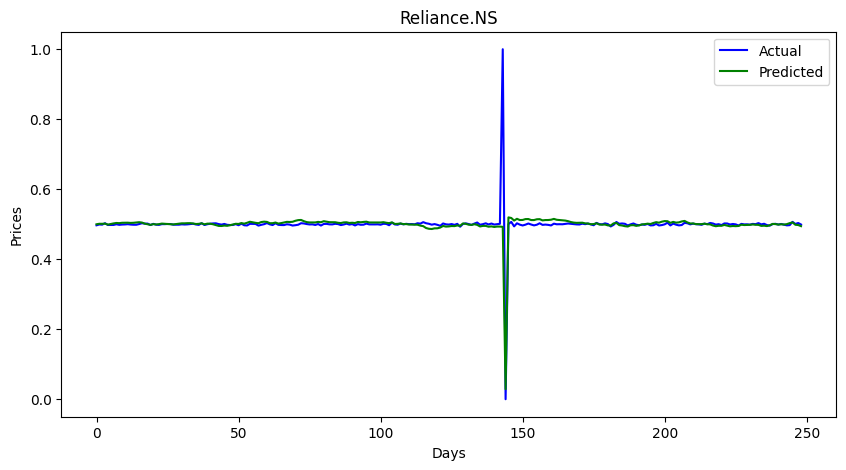

In [19]:
from stockFunctions import graph
graph(data1,y_pred,"Actual","Predicted","Reliance.NS","Days","Prices")

In [20]:
len(data1)

249

In [21]:
from stockFunctions import conversionSingle
aTestNormTable=conversionSingle(data1,["Close"])
actual_stock_price_test_ori=Ms.inverse_transform(aTestNormTable)
actual_stock_price_test_oriA=conversionSingle(actual_stock_price_test_ori,["Close"])

In [22]:
from stockFunctions import conversionSingle
pTestNormTable=conversionSingle(y_pred,["Close"])
predicted_stock_price_test_ori=Ms.inverse_transform(pTestNormTable)
predicted_stock_price_test_oriP=conversionSingle(predicted_stock_price_test_ori,["Close"])

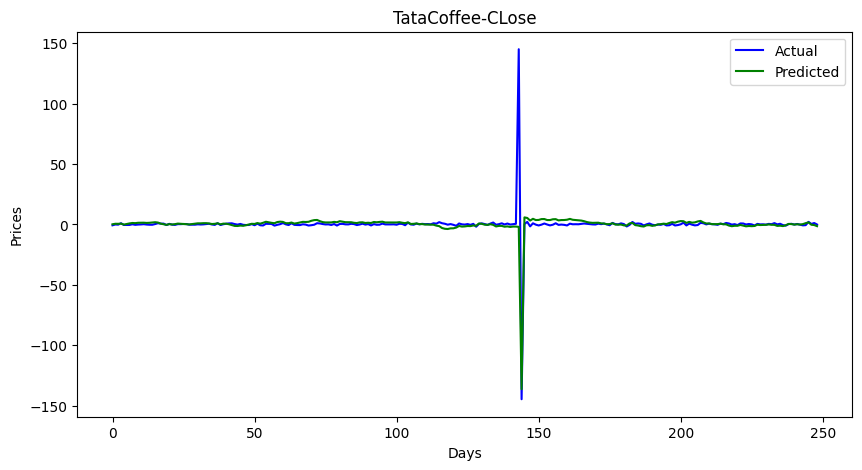

In [23]:
from stockFunctions import graph
graph(actual_stock_price_test_oriA,predicted_stock_price_test_oriP,"Actual","Predicted","Reliance.NS
","Days","Prices")

In [24]:
from stockFunctions import rmsemape
rmsemape(actual_stock_price_test_oriA,predicted_stock_price_test_oriP)

RMSE-Testset: 9.509688418556204
MAPE-Testset: 13368694773777.79


In [25]:
forecast=model_fit.predict(len(data1), len(data1)+3)

In [26]:
forecast

array([0.49542133, 0.4997728 , 0.4998363 , 0.49983722])

In [27]:
from stockFunctions import conversionSingle
fTestNormTable=conversionSingle(forecast,["Closefore"])
forecast_stock_price_test_ori=Ms.inverse_transform(fTestNormTable)
forecast_stock_price_test_oriF=conversionSingle(forecast_stock_price_test_ori,["Closefore"])

In [28]:
forecast_stock_price_test_oriF.to_csv("Closets.csv",index=False)

In [29]:
forecast_stock_price_test_oriF

,Closefore
0,-1.188157
1,0.072512
2,0.090908
3,0.091176
